
Rice, one of the most extensively cultivated grains globally, exhibits a wide array of genetic variations, each distinguished by specific characteristics such as texture, shape, and color. These distinguishing features enable the classification and assessment of seed quality.




In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")


GPU is available
GPU name: Tesla T4


In [2]:
!pip install keras

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import time
import random
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tabulate import tabulate
from termcolor import colored
import matplotlib.pyplot as plt
from IPython.display import display
from keras.models import Sequential
from keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
sns.set_style('whitegrid')

In [4]:
!wget https://github.com/Abhishek-guptaaa/My_dataset1/raw/refs/heads/main/Rice_Image_Dataset.zip


--2024-10-03 05:33:29--  https://github.com/Abhishek-guptaaa/My_dataset1/raw/refs/heads/main/Rice_Image_Dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/Abhishek-guptaaa/My_dataset1/refs/heads/main/Rice_Image_Dataset.zip [following]
--2024-10-03 05:33:30--  https://media.githubusercontent.com/media/Abhishek-guptaaa/My_dataset1/refs/heads/main/Rice_Image_Dataset.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229378744 (219M) [application/zip]
Saving to: ‘Rice_Image_Dataset.zip’

Rice_Image_Dataset. 100%[===================>] 218.75M   168MB/s    in 1.3s    

20

In [5]:
import zipfile

# Path to the downloaded zip file
zip_file_path = "/content/Rice_Image_Dataset.zip"

# Open and extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to 'Rice_Image_Dataset' folder

print("Extraction complete!")


Extraction complete!


In [6]:
dir1 = '/content/Rice_Image_Dataset'
# Detect classes
detection = [class_name for class_name in os.listdir(dir1) if class_name]
detection.remove('Rice_Citation_Request.txt')
print(detection)

['Ipsala', 'Jasmine', 'Basmati', 'Karacadag', 'Arborio']


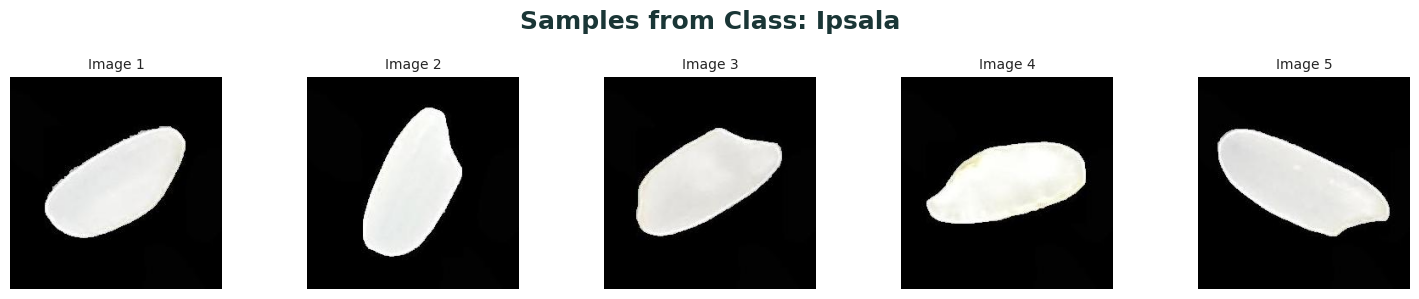

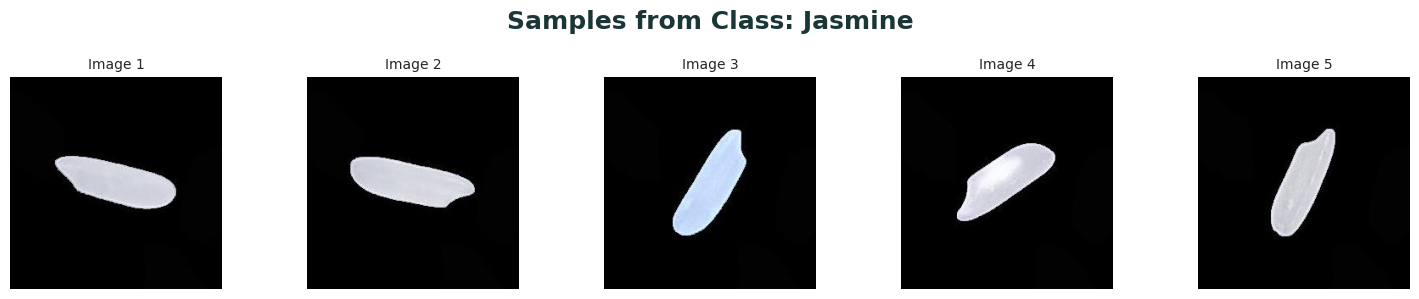

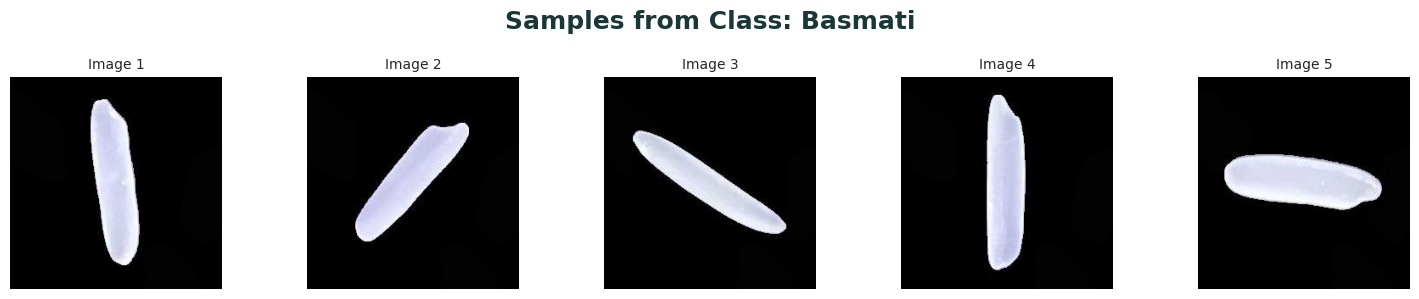

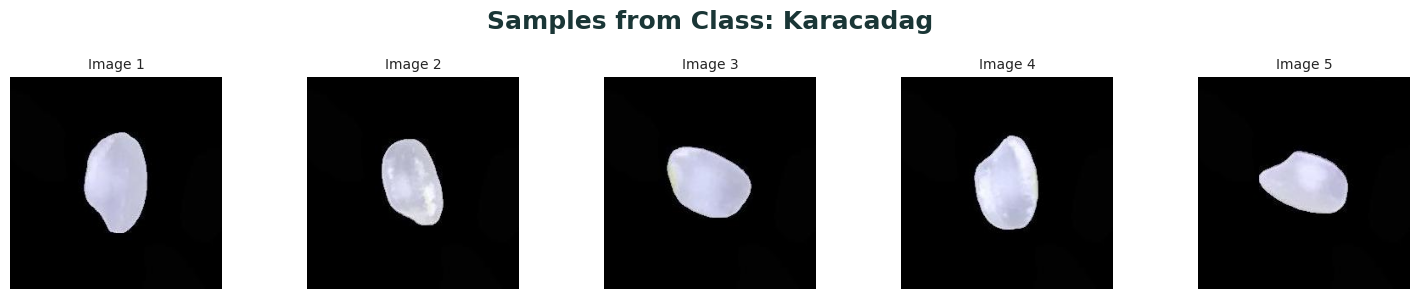

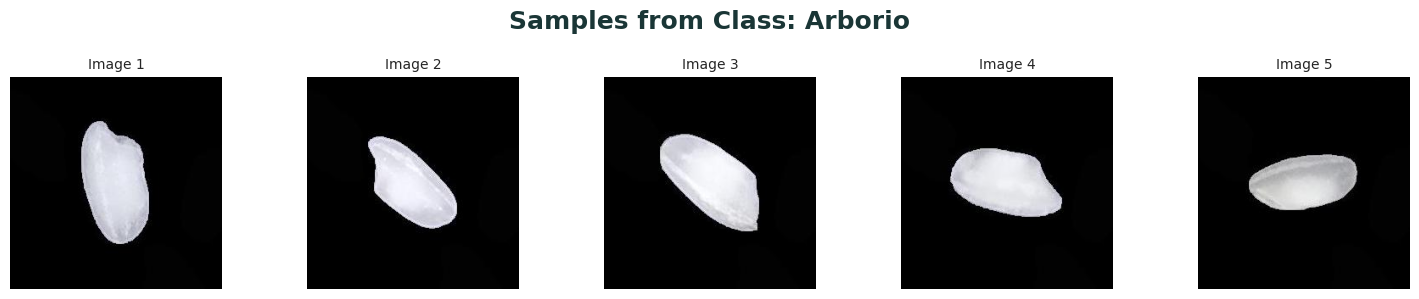

In [7]:
# Plot and Count Images
for class_name in detection:
    # Prepare class path
    class_path = os.path.join(dir1, class_name)
    # List images
    images = os.listdir(class_path)
    random_images = random.choices(images, k=5)

    # Create a figure with improved aesthetics
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    plt.suptitle(f'Samples from Class: {class_name}', fontsize=18, fontweight='bold', color='#1A3636')

    for i in range(5):
        # Load and display the image
        img_path = os.path.join(class_path, random_images[i])
        img = keras.utils.load_img(img_path)
        ax[i].imshow(img)
        ax[i].axis('off')  # Remove axis

        # Optionally, add image title
        ax[i].set_title(f'Image {i + 1}', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()  # Display the figure


In [8]:
# Create a list of tuples that contain image paths and their class labels
image_data = []  # Initialize an empty list for storing image paths and labels

# Iterate through each class in the detection
for class_name in detection:
    class_path = os.path.join(dir1, class_name)  # Create the path for the class
    files = os.listdir(class_path)  # List all files in the class folder

    # Loop through all files and add their paths and class labels to the image_data list
    for file in files:
        file_path = os.path.join(class_path, file)  # Create the full file path
        image_data.append((file_path, class_name))  # Append tuple to the list

# Convert the list to a pandas DataFrame
df = pd.DataFrame(image_data, columns=['path', 'label'])

# Shuffle the DataFrame rows for randomness
df = df.sample(frac=1).reset_index(drop=True)

# Display the first few entries of the DataFrame
display(df.head())  # Change from print to display

,path,label
0,/content/Rice_Image_Dataset/Basmati/basmati (1...,Basmati
1,/content/Rice_Image_Dataset/Ipsala/Ipsala (644...,Ipsala
2,/content/Rice_Image_Dataset/Arborio/Arborio (6...,Arborio
3,/content/Rice_Image_Dataset/Basmati/basmati (1...,Basmati
4,/content/Rice_Image_Dataset/Ipsala/Ipsala (561...,Ipsala


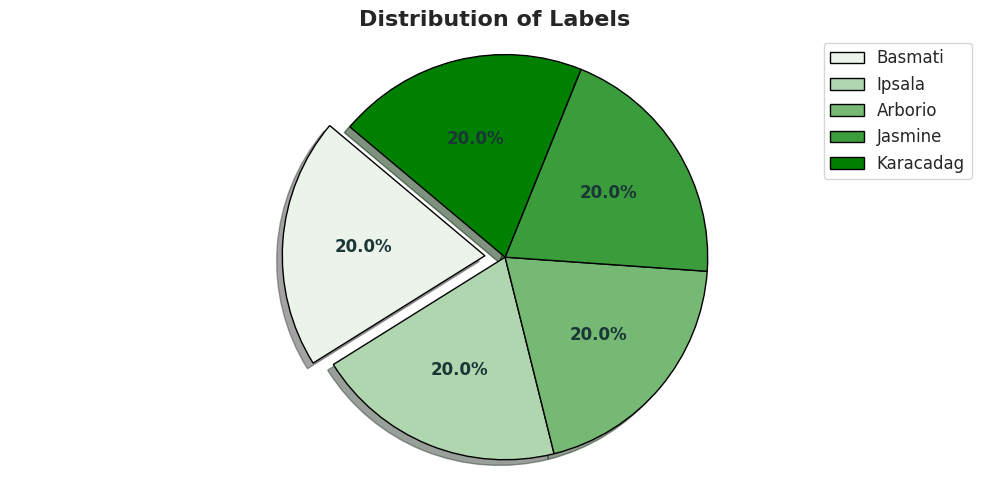

In [9]:
def label_counter(dataframe):
    """Plot a pie chart to show the distribution of labels in the dataframe."""
    fig, ax = plt.subplots(figsize=(10, 5))
    labels = dataframe['label'].value_counts().index
    sizes = dataframe['label'].value_counts().values

    # Define a color palette with shades of green
    colors = sns.light_palette("green", n_colors=len(labels), as_cmap=False)

    # Create the pie chart
    wedges, texts, autotexts = ax.pie(sizes, colors=colors,
                                      autopct='%1.1f%%', startangle=140,
                                      explode=(0.1, *([0] * (len(labels) - 1))),
                                      wedgeprops=dict(edgecolor='black'), shadow=True)

    # Set title and equal axis
    ax.set_title('Distribution of Labels', fontsize=16, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Create legend
    ax.legend(wedges, labels, loc="best", fontsize=12)

    # Customize text properties
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
        text.set_color('#1a3636')  # Dark green for labels

    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
        autotext.set_color('#1a3636')

    plt.tight_layout()
    plt.show()

# Call the function to display the label distribution
label_counter(df)

In [10]:
total_samples = len(df)
print(colored(f'Total number of samples: {total_samples}', 'green', attrs=['underline']))

training_data = df[:60000]
validation_data = df[60000:67500]
test_data = df[67500:]

training_data.reset_index(inplace=True, drop=True)
validation_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

print(colored(f'Number of samples in Training df: {len(training_data)}', attrs=['bold']))
print(colored(f'Number of samples in Validation df: {len(validation_data)}', attrs=['bold']))
print(colored(f'Number of samples in Test df: {len(test_data)}', attrs=['bold']))

Total number of samples: 75000
Number of samples in Training df: 60000
Number of samples in Validation df: 7500
Number of samples in Test df: 7500


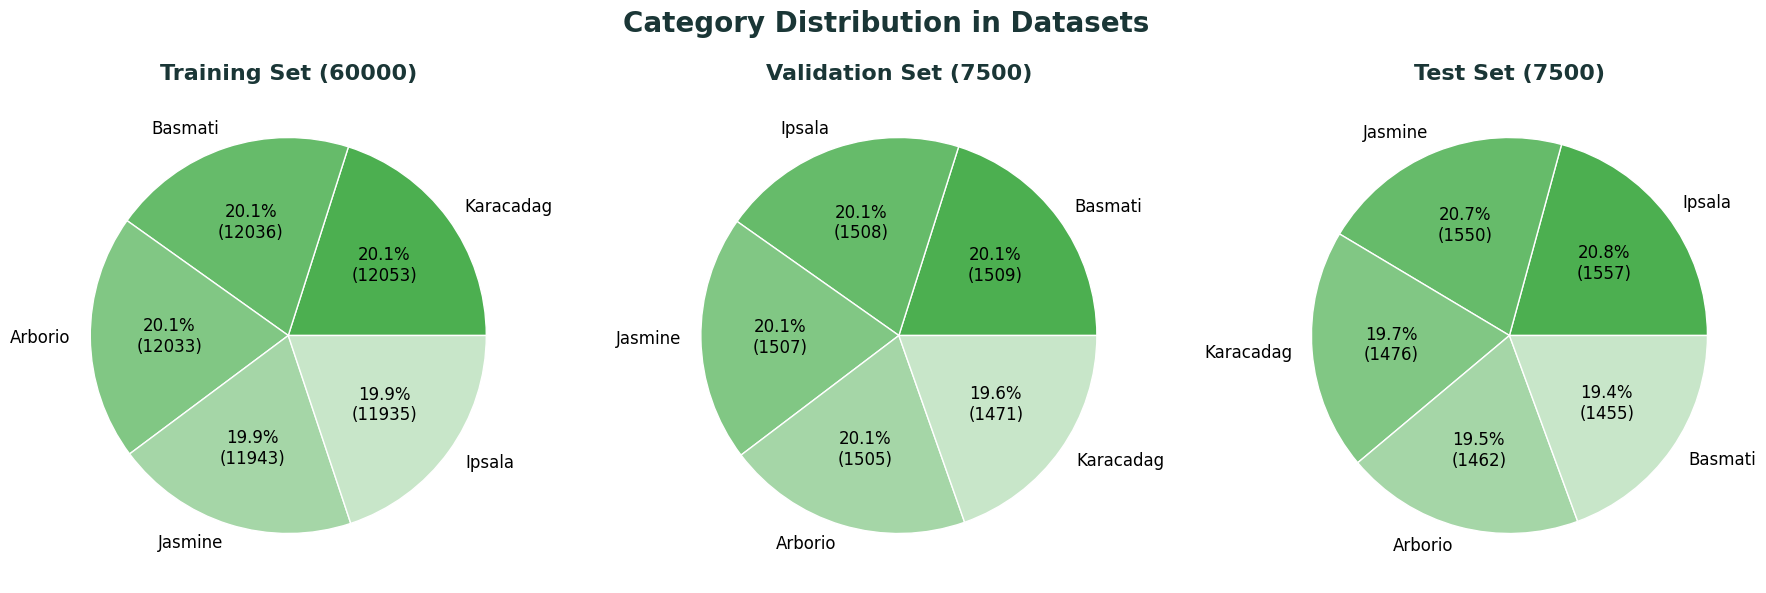

In [11]:
def train_calidate_test_plot():
    # Define a green color palette for the pie charts
    colors = ['#4CAF50', '#66BB6A', '#81C784', '#A5D6A7', '#C8E6C9',
              '#DCE775', '#FFEB3B', '#FF9800', '#FF5722', '#F44336']

    # Get the category counts for the entire dataset
    category_counts = df['label'].value_counts()
    categories = category_counts.index.tolist()
    counts = category_counts.values.tolist()

    # Create a figure with subplots for Training, Validation, and Test sets
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Loop through each dataset subset
    for i, (subset, subset_name) in enumerate(zip([training_data, validation_data, test_data], ['Training Set', 'Validation Set', 'Test Set'])):
        subset_category_counts = subset['label'].value_counts()
        subset_counts = subset_category_counts.values.tolist()

        total_count = len(subset)
        percentages = [count / total_count * 100 for count in subset_counts]

        # Create a pie chart for each subset
        wedges, _, autotexts = axs[i].pie(
            subset_counts,
            labels=subset_category_counts.index,
            autopct=lambda p: f'{p:.1f}%\n({total_count * p / 100:.0f})',
            colors=colors,
            textprops={'color': 'black', 'fontsize': 12}
        )

        # Set title with total count
        axs[i].set_title(f'{subset_name} ({total_count})', fontsize=16, fontweight='bold', color='#1A3636')

        # Adjust text alignment for percentage annotations
        for autotext in autotexts:
            autotext.set_horizontalalignment('center')
            autotext.set_verticalalignment('center')

    plt.suptitle('Category Distribution in Datasets', fontsize=20, fontweight='bold', color='#1A3636')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the top margin to fit the title
    plt.show()

# Call the function to plot the distributions
train_calidate_test_plot()

# Data Generator, Normalization & Modeling

* Setting Image Dimensions and Batch Size

    The image dimensions are set to 224x224 pixels, and the batch size is configured to 16.

* Initializing the ImageDataGenerator for Normalization

    The ImageDataGenerator is initialized with normalization applied to the images using the rescale=1.0/255 parameter. This step scales the pixel values from the range of [0, 255] to [0, 1], which is essential for the model's performance and stability.

* Creating Data Generators

    The function create_data_generator is defined to generate data from a DataFrame. It takes the DataFrame and a boolean flag indicating whether the generator is for training data. The generator uses the flow_from_dataframe method to load images based on specified file paths (x_col='path') and labels (y_col='label'). The images are resized to the target size, batched accordingly, and categorized using
    class_mode='categorical'. The shuffle parameter is set to true for training data to ensure randomization.

* Generators for Training, Validation, and Test Datasets

    Three data generators are created: train_generator for the training dataset, valid_generator for the validation dataset, and test_generator for the test dataset. The training generator is shuffled, while the validation and test generators maintain a consistent order.

* Defining the Model Input Shape

    The input shape for the model is set to (224, 224, 3), representing the dimensions of the input images.

* Building the Custom CNN Model

    A sequential model is constructed using convolutional, max pooling, and fully connected layers. The model architecture includes:

    A convolutional layer with 32 filters of size 3x3, followed by batch normalization and a max pooling layer.
    Another convolutional layer with 64 filters, followed by batch normalization and another max pooling layer.
    After flattening the output, two dense layers with 512 and 64 units are added, each followed by dropout layers for regularization. The final output layer has a softmax activation function, corresponding to the number of unique classes in the training data.

* Compiling the Model

    The model is compiled using the categorical crossentropy loss function, Adadelta optimizer with a learning rate of 0.01, and accuracy as the evaluation metric.

* Model Summary

    A summary of the model architecture is displayed, providing an overview of the layers and parameters.

In [12]:
# Set image dimensions and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

# Initialize the ImageDataGenerator for image normalization
data_gen = ImageDataGenerator(rescale=1.0/255)

# Function to create data generators
def create_data_generator(dataframe, is_training=False):
    return data_gen.flow_from_dataframe(
        dataframe,
        x_col='path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=is_training)

# Create generators for training, validation, and test datasets
train_generator = create_data_generator(training_data, is_training=True)
valid_generator = create_data_generator(validation_data, is_training=False)
test_generator = create_data_generator(test_data, is_training=False)

# Set the input shape of the model
input_shape = (224, 224, 3)

# Build the custom CNN model
model = Sequential()

# Convolutional and MaxPooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))  # Convolutional layer with 32 filters of size 3x3
model.add(BatchNormalization())  # Normalizes the output of the previous layer
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling layer to reduce dimensions

model.add(Conv2D(64, (3, 3), activation='relu'))  # Another convolutional layer with 64 filters
model.add(BatchNormalization())  # Normalize again
model.add(MaxPooling2D(pool_size=(2, 2)))  # Another max pooling layer

# Flatten the output and add Dense layers
model.add(Flatten())  # Converts the 2D matrix to a 1D vector
model.add(Dense(512, activation='relu'))  # Fully connected layer with 512 units
model.add(Dropout(0.5))  # Dropout layer for regularization
model.add(Dense(64, activation='relu'))  # Another dense layer with 64 units
model.add(Dropout(0.5))  # Another dropout layer
model.add(Dense(len(training_data['label'].unique()), activation='softmax'))  # Output layer for the number of classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(learning_rate=0.01), metrics=['accuracy'])

# Summary of the model
model.summary()

print("Custom CNN model is built and ready for training!")

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      95,552,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,604,933 (364.70 MB)

 Trainable params: 95,604,741 (364.70 MB)

 Non-trainable params: 192 (768.00 B)

Custom CNN model is built and ready for training!


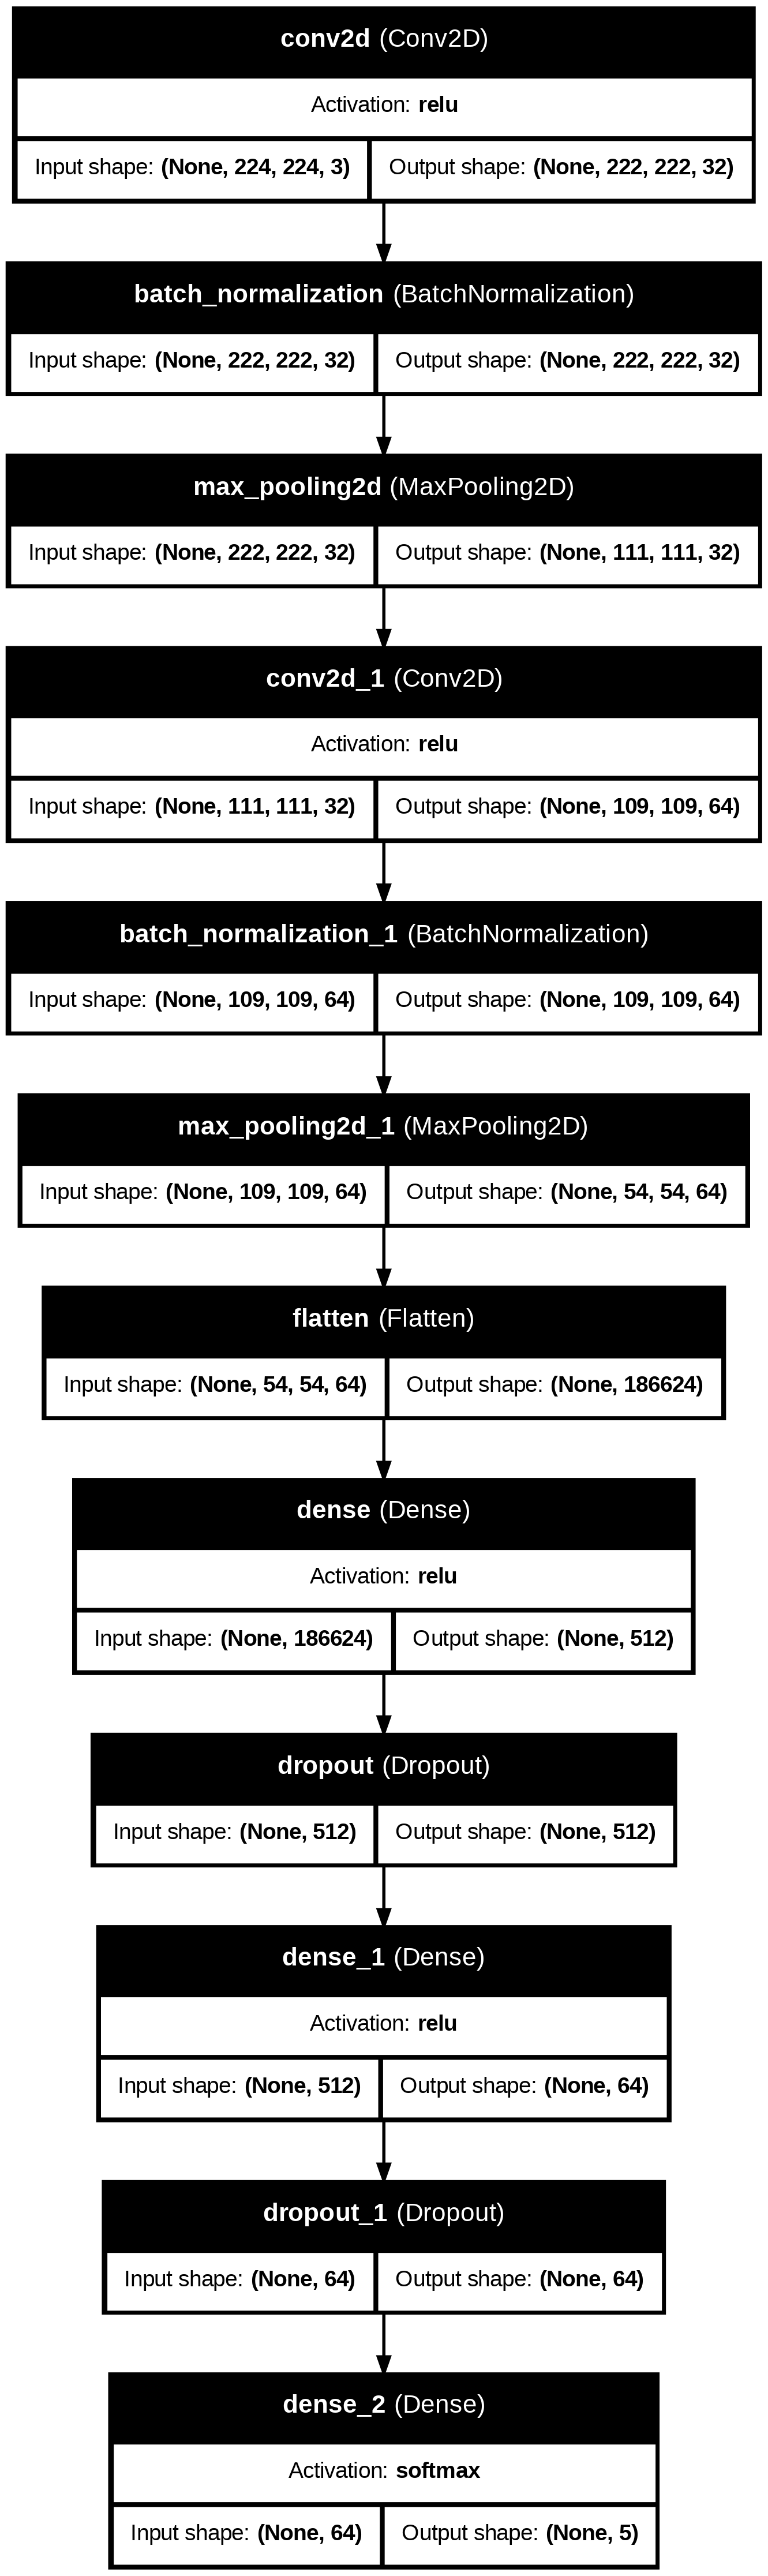

In [13]:
keras.utils.plot_model(
    model,                        # An instance of a Keras model
    to_file="model.png",          # "name.format" to specify the saved file name
    show_shapes=True,            # Option to display shape information
    show_dtype=False,             # Option to display layer data types
    show_layer_names=True,       # Option to display names of layers
    rankdir="TB",                 # A parameter for the PyDot library
    expand_nested=False,          # Option to expand nested Functional models into clusters
    dpi=200,                      # Resolution of the image in dots per inch
    show_layer_activations=True, # Option to show layer activations
    show_trainable=False)         # Option to indicate if a layer is trainable


In [14]:
# A callback is an object that facilitates actions at different points during training,
# such as at the beginning or end of an epoch, or before and after processing a batch.
# Callbacks can be utilized to:
# Implement early stopping
# Periodically save the model to disk
# Log metrics to TensorBoard after each training batch
# Monitor internal states and statistics of the model during training & ...

# Model Checkpoint Callback to save the best model parameters as a .keras file
checkpoint_callback = keras.callbacks.ModelCheckpoint('BestModel.keras', save_best_only=True)

# ReduceLROnPlateau Callback to decrease the learning rate based on the 'monitor' parameter after a specified 'patience' period if no improvement is observed
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [15]:
# Model Training
numepochs = 10

# Start the timer
start_time = time.time()

history = model.fit(train_generator, epochs=numepochs, validation_data=test_generator,
                    callbacks=[checkpoint_callback, reduce_learning_rate])

# Stop the timer
end_time = time.time()

# Calculate and print the total training time
training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 198s 50ms/step - accuracy: 0.7833 - loss: 0.6423 - val_accuracy: 0.9865 - val_loss: 0.0453 - learning_rate: 0.0100
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 215s 55ms/step - accuracy: 0.9663 - loss: 0.1170 - val_accuracy: 0.9924 - val_loss: 0.0360 - learning_rate: 0.0100
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 222s 45ms/step - accuracy: 0.9756 - loss: 0.0935 - val_accuracy: 0.9920 - val_loss: 0.0375 - learning_rate: 0.0100
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 291s 69ms/step - accuracy: 0.9796 - loss: 0.0817 - val_accuracy: 0.9912 - val_loss: 0.0353 - learning_rate: 0.0100
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 168s 45ms/step - accuracy: 0.9831 - loss: 0.0661 - val_accuracy: 0.9931 - val_loss: 0.0410 - learning_rate: 0.0100
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 202s 45ms/step - accuracy: 0.9845 - loss: 0.0661 - val_accuracy: 0.9935 - val_loss: 0.0375 - learning_rate: 0.0100
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 166s 44ms/step -

In [16]:
# Convert result of training to a df
result_df = pd.DataFrame(history.history)
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+------------+-----------+----------------+------------+-----------------+
|    |   accuracy |      loss |   val_accuracy |   val_loss |   learning_rate |
|----+------------+-----------+----------------+------------+-----------------|
|  0 |   0.883733 | 0.34487   |       0.986533 |  0.0453145 |           0.01  |
|  1 |   0.969717 | 0.105876  |       0.9924   |  0.0359583 |           0.01  |
|  2 |   0.977267 | 0.0886124 |       0.992    |  0.0375182 |           0.01  |
|  3 |   0.9807   | 0.0781736 |       0.9912   |  0.0353006 |           0.01  |
|  4 |   0.982717 | 0.0705543 |       0.993067 |  0.0410443 |           0.01  |
|  5 |   0.984333 | 0.0667555 |       0.993467 |  0.0374517 |           0.01  |
|  6 |   0.98435  | 0.065331  |       0.992533 |  0.036354  |           0.01  |
|  7 |   0.987833 | 0.0558795 |       0.993067 |  0.0319791 |           0.005 |
|  8 |   0.9876   | 0.0559246 |       0.992667 |  0.0334447 |           0.005 |
|  9 |   0.988233 | 0.053657  |       0.

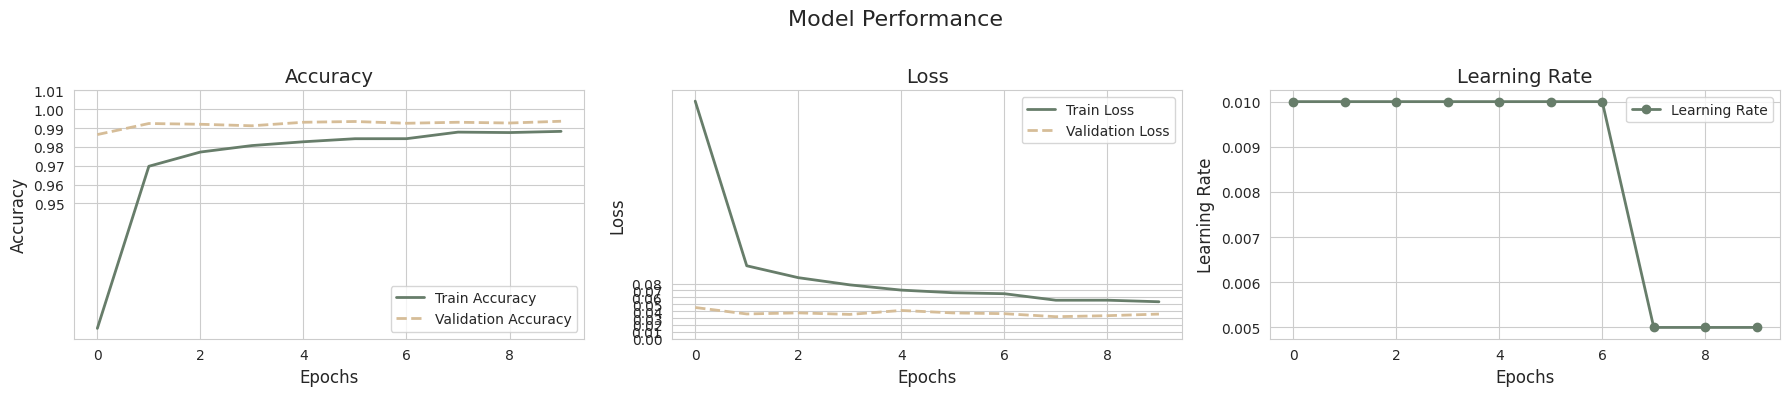

In [17]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Initialize figure and axes for side-by-side plots
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('Model Performance', fontsize=16)

# ax[0] ---> Accuracy
ax[0].plot(x, result_df.accuracy, label='Train Accuracy', linewidth=2, color='#677D6A')
ax[0].plot(x, result_df.val_accuracy, label='Validation Accuracy', linewidth=2, linestyle='--', color='#D6BD98')
ax[0].set_title('Accuracy', fontsize=14)
ax[0].set_yticks(np.arange(0.95, 1.01, 0.01))
ax[0].set_xticks(np.arange(0, len(result_df), 2))
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].legend()
ax[0].grid(True)

# ax[1] ---> Loss
ax[1].plot(x, result_df.loss, label='Train Loss', linewidth=2, color='#677D6A')
ax[1].plot(x, result_df.val_loss, label='Validation Loss', linewidth=2, linestyle='--', color='#D6BD98')
ax[1].set_title('Loss', fontsize=14)
ax[1].set_xticks(np.arange(0, len(result_df), 2))
ax[1].set_yticks(np.arange(0, 0.085, 0.01))
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend()
ax[1].grid(True)

# ax[2] ---> Learning Rate
ax[2].plot(x, result_df.learning_rate, label='Learning Rate', linewidth=2, marker='o', color='#677D6A')
ax[2].set_title('Learning Rate', fontsize=14)
ax[2].set_xticks(np.arange(0, len(result_df), 2))
ax[2].set_xlabel('Epochs', fontsize=12)
ax[2].set_ylabel('Learning Rate', fontsize=12)
ax[2].legend()
ax[2].grid(True)

# Adjust layout to make room for the super title
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [18]:
# Load the optimal model weights saved in "BestModel.keras" after training
best_model = keras.models.load_model('BestModel.keras')

# Evaluate the model's performance on the test dataset
loss, accuracy = best_model.evaluate(test_generator)

# Display the evaluation results with clear and formatted output
print("\nModel Evaluation Results:")
print(colored(f'Loss: {loss:.5f}',attrs=['bold']))
print(colored(f'Accuracy: {accuracy * 100:.2f}%',attrs=['bold']))

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9926 - loss: 0.0313

Model Evaluation Results:
Loss: 0.03198
Accuracy: 99.31%


In [ ]:
# Reset the test data generator to start from the beginning.
test_generator.reset()

# Get the next batch of images and their corresponding labels from the test generator.
img, label = next(test_generator)

# Generate predictions for the batch of images using the trained model.
predictions = model.predict(img)

# Extract the predicted classes from the model's output.
test_pred_classes = np.argmax(predictions, axis=1)

# Set up the plot with a larger figure size for better clarity.
plt.figure(figsize=[16, 16])

# Loop through the first 16 images in the batch to display them along with their labels and predictions.
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    plt.axis('off')  # Hide the axes for a cleaner look

    # Title with the true label, predicted class, and prediction confidence percentage
    plt.title(f"Label: {detection[np.argmax(label[i])]}\n"
              f"Prediction: {detection[test_pred_classes[i]]} "
              f"({100 * np.max(predictions[i]):.1f}%)",
              fontsize=12, color='#1A3636')

# Adjust the layout to prevent overlapping of elements
plt.tight_layout()
plt.show()

In [ ]:
# Generate predictions on the test set
print("Generating predictions on the test set...")
y_pred = model.predict(test_generator, verbose=1)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate a classification report
print("\nClassification Report:")
clf = classification_report(test_generator.classes, y_pred_classes, target_names=detection)

# Print the classification report with some formatting
print("="*50)
print("Detailed Classification Report")
print("="*50)
print(clf)
print("="*50)

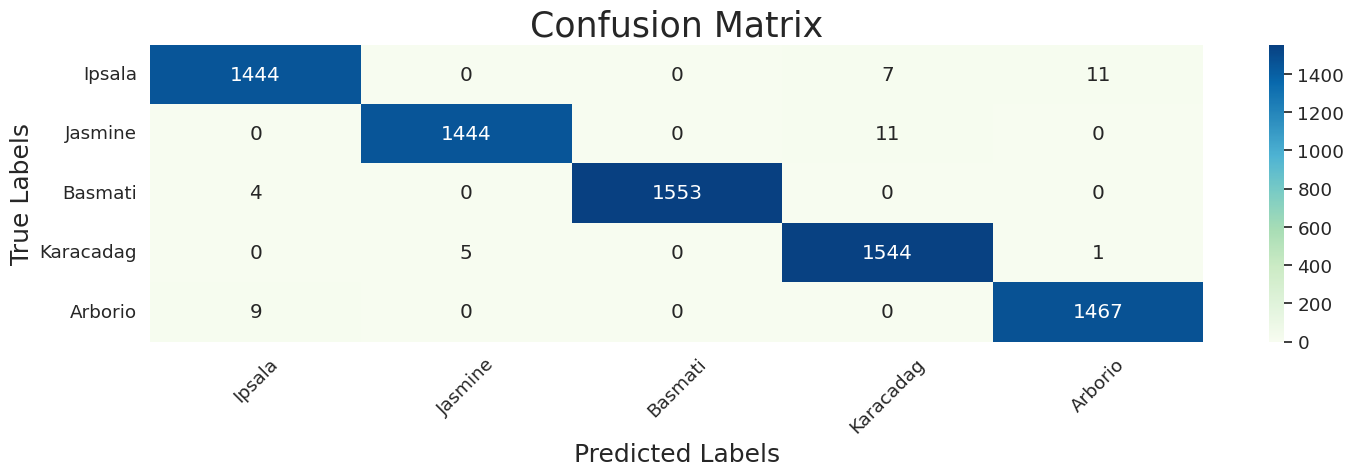

In [21]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot the confusion matrix for the classification results."""
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set up the figure
    plt.figure(figsize=(15, 5))
    sns.set(font_scale=1.2)  # Increase font size for better readability

    # Create heatmap for the confusion matrix
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap="GnBu", cbar=True)

    # Set labels and title
    ax.set_xlabel('Predicted Labels', fontsize=18)
    ax.set_ylabel('True Labels', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=25)

    # Set tick labels
    ax.xaxis.set_ticklabels(detection, rotation=45)
    ax.yaxis.set_ticklabels(detection, rotation=0)

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(test_generator.classes, y_pred_classes)

### The confusion matrix above highlights several key elements in the evaluation of the classification model:

* True Positives (TP): The number of instances correctly classified as belonging to a certain class.
* True Negatives (TN): The number of instances correctly classified as not belonging to a certain class.
* False Positives (FP): The number of instances incorrectly classified as belonging to a certain class when they do not.
* False Negatives (FN): The number of instances incorrectly classified as not belonging to a certain class when they actually do. From the confusion matrix, we can observe the model's ability to correctly predict classes (high TP and TN) and identify areas where the model may struggle, as indicated by the FP and FN values. This analysis provides a clear understanding of the model's performance across different classes.